# CS 7641 Assignment1 - Supervised Learning
This assignment is to implement and analyze 5 different classification algorithms for two datasets.<br>
The datasets used are: Phishing Websites and Breast Cancer Wisconsin(Diagnostic)<br>
The classification algorithms are: Decision Tree, kNN, Neural Network, SVM and Boosting.<br>

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, confusion_matrix
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier as kNN
import time
import timeit
import itertools
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading the datasets

In [19]:
cancer_data = pd.read_csv('breast_cancer.csv')
print("Data has",len(cancer_data),"rows and", len(cancer_data.columns),"columns.")

('Data has', 569, 'rows and', 33, 'columns.')


In [20]:
phishing_data = pd.read_csv('PhishingWebsites.csv')
print("Data has",len(phishing_data),"rows and", len(phishing_data.columns),"columns.")

('Data has', 11055, 'rows and', 31, 'columns.')


# Preprocessing datasets

This section is preprocessing the breast cancer dataset. Like dropping unnecessary columns and replacing the values of target to 0/1 numeric values.

In [26]:
y_can = cancer_data.diagnosis  # malignant (M) or benign (B)
# The column "Unnamed: 32" feature includes NaN so drop it from the data. Also drop "id" as it is not a feature and
# "diagnosis" as it is the label
column_names = ['Unnamed: 32', 'id', 'diagnosis']
X_can = cancer_data.drop(column_names, axis=1)
X_can = preprocessing.scale(X_can)

# Convert string labels to numerical values
y_can = y_can.values
y_can[y_can == 'M'] = 1
y_can[y_can == 'B'] = 0
y_can = y_can.astype(int)
column_order = list(cancer_data)
column_order.insert(0, column_order.pop(column_order.index('diagnosis'))) #move target diagnosis to front
cancer_data = cancer_data.loc[:, column_order]
cancer_data.describe(include='all')

,diagnosis,id,radius,texture,perimeter,area,smoothness,compactness,concavity,concave points,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,569.0,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
unique,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,357.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,NaN,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,NaN,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,NaN,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,NaN,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,NaN,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN


For preprocessing the phishing dataset, there are several columns that are categorical with the levels {-1,0,1} and the rest are all binary with levels {-1,1}. For the 3-level columns one-hot encoding was used to create additional features with level {0,1}. Finally, edited the binary features so that the new levels are all {0,1}. There are more features now, but it will all be binary.

In [28]:
column_names = ['URL_Length','having_Sub_Domain','SSLfinal_State','URL_of_Anchor','Links_in_tags','SFH','web_traffic','Links_pointing_to_page']
data_1hot = phishing_data[column_names]
data_1hot = pd.get_dummies(data_1hot)
data_others = phishing_data.drop(column_names,axis=1)
phishing_data = pd.concat([data_1hot,data_others],axis=1)
phishing_data = phishing_data.replace(-1,0).astype('category')
column_order = list(phishing_data)
column_order.insert(0, column_order.pop(column_order.index('Result')))
phishing_data = phishing_data.loc[:, column_order]  #move the target variable 'Result' to the front
phishing_data.describe(include='all')

,Result,URL_Length,having_Sub_Domain,SSLfinal_State,URL_of_Anchor,Links_in_tags,SFH,web_traffic,Links_pointing_to_page,having_IP_Address,...,Redirect,on_mouseover,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,Page_Rank,Google_Index,Statistical_report
count,11055,11055,11055,11055,11055,11055,11055,11055,11055,11055,...,11055,11055,11055,11055,11055,11055,11055,11055,11055,11055
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,1,0,0,1,0,0,0,1,0,1,...,0,1,1,1,1,1,1,0,1,1
freq,6157,9095,6985,6331,8619,8405,9201,5831,6704,7262,...,9776,9740,10579,8918,10043,5866,7612,8201,9516,9505


# Splitting the datasets
The datasets are now split into train and test datasets. Training dataset is 70% of the original dataset while test dataset is 30% of the original dataset.

In [83]:
X_can_train, X_can_test, y_can_train, y_can_test = train_test_split(X_can, y_can, test_size=0.3, random_state=18)

X_phish = np.array(phishing_data.values[:,1:],dtype='int64')
y_phish = np.array(phishing_data.values[:,0],dtype='int64')
X_ph_train, X_ph_test, y_ph_train, y_ph_test = train_test_split(X_phish, y_phish, test_size=0.3, random_state=18)

In [41]:
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['font.size'] = 12

def plot_learning_curve(clf, num_fold, X, y, title="Insert Title"):
    n = len(y)
    train_mean = []; train_std = [] #model performance score (f1)
    cv_mean = []; cv_std = [] #model performance score (f1)
    fit_mean = []; fit_std = [] #model fit/training time
    pred_mean = []; pred_std = [] #model test/prediction times
    train_sizes=(np.linspace(.05, 1.0, 20)*n).astype('int')  
    
    for i in train_sizes:
        idx = np.random.randint(X.shape[0], size=i)
        X_subset = X[idx,:]
        y_subset = y[idx]
        scores = cross_validate(clf, X_subset, y_subset, cv=num_fold, scoring='f1', n_jobs=-1, return_train_score=True)
        
        train_mean.append(np.mean(scores['train_score'])); train_std.append(np.std(scores['train_score']))
        cv_mean.append(np.mean(scores['test_score'])); cv_std.append(np.std(scores['test_score']))
        fit_mean.append(np.mean(scores['fit_time'])); fit_std.append(np.std(scores['fit_time']))
        pred_mean.append(np.mean(scores['score_time'])); pred_std.append(np.std(scores['score_time']))
    
    train_mean = np.array(train_mean); train_std = np.array(train_std)
    cv_mean = np.array(cv_mean); cv_std = np.array(cv_std)
    fit_mean = np.array(fit_mean); fit_std = np.array(fit_std)
    pred_mean = np.array(pred_mean); pred_std = np.array(pred_std)
    
    plot_LC(train_sizes, train_mean, train_std, cv_mean, cv_std, title)
    
    return train_sizes, train_mean, fit_mean, pred_mean
    

def plot_LC(train_sizes, train_mean, train_std, cv_mean, cv_std, title):
    plt.figure()
    plt.title("Learning Curve: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model F1 Score")
    plt.fill_between(train_sizes, train_mean - 2*train_std, train_mean + 2*train_std, alpha=0.1, color="b")
    plt.fill_between(train_sizes, cv_mean - 2*cv_std, cv_mean + 2*cv_std, alpha=0.1, color="r")
    plt.plot(train_sizes, train_mean, 'o-', color="g", label="Training Score")
    plt.plot(train_sizes, cv_mean, 'o-', color="r", label="Cross-Validation Score")
    plt.legend(loc="best")
    plt.show()
    
def plot_roc(fpr, tpr, title):
    
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC Curve: "+ title)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.plot(fpr, tpr)
    plt.legend(loc="best")
    plt.show()
       
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(2), range(2)):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    
def final_classifier_evaluation(clf,X_train, X_test, y_train, y_test, title):
    
    start_time = timeit.default_timer()
    clf.fit(X_train, y_train)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    start_time = timeit.default_timer()    
    y_pred = clf.predict(X_test)
    y_pred_rt = clf.predict_proba(X_test)[:,1]
    end_time = timeit.default_timer()
    pred_time = end_time - start_time
    
    auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    cm = confusion_matrix(y_test,y_pred)
    fpr_lm, tpr_lm, _ = roc_curve(y_test, y_pred_rt)
    plot_roc(fpr_lm, tpr_lm, title)
    print("Model Evaluation Metrics Using Untouched Test Dataset")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.5f}".format(training_time))
    print("Model Prediction Time (s): "+"{:.5f}\n".format(pred_time))
    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy)+"     AUC:       "+"{:.2f}".format(auc))
    print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
    plt.figure()
    plot_confusion_matrix(cm, classes=["0","1"], title='Confusion Matrix')
    plt.show()
    return fpr_lm, tpr_lm

# Decision Tree Classifier
In this section constructed a Decision Tree Classifier using information gain (based on entropy) to determine the best feature split per the ID3 algorithm. The model will be pre-pruned by limiting tree depth using the hyperparameter 'max_depth' and by ensuring that each leaf (a terminal node on the tree) has at least 'min_samples_leaf'.

In [42]:
def DTree_classifier(X_train, y_train, X_test, y_test, title):
    f1_test = []
    f1_train = []
    max_depth = list(range(1,31))
    for i in max_depth:         
            clf = DecisionTreeClassifier(max_depth=i, random_state=100, min_samples_leaf=1, criterion='entropy')
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(f1_score(y_test, y_pred_test))
            f1_train.append(f1_score(y_train, y_pred_train))
      
    plt.plot(max_depth, f1_test, 'o-', color='r', label='Test F1 Score')
    plt.plot(max_depth, f1_train, 'o-', color = 'g', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('Max Tree Depth')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
     
    
def TreeGridSearchCV(start_leaf_n, end_leaf_n, X_train, y_train):
    #parameters to search:
    #20 values of min_samples leaf from 0.5% sample to 5% of the training data
    #20 values of max_depth from 1, 20
    param_grid = {'min_samples_leaf':np.linspace(start_leaf_n,end_leaf_n,20).round().astype('int'), 'max_depth':np.arange(1,20)}

    tree = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid=param_grid, cv=10)
    tree.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(tree.best_params_)
    return tree.best_params_['max_depth'], tree.best_params_['min_samples_leaf']

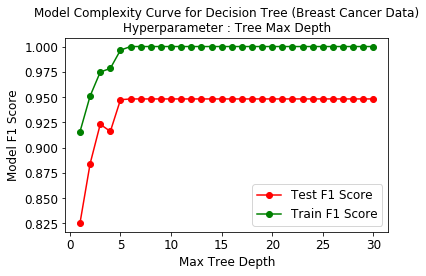

Per Hyperparameter tuning, best parameters are:
{'max_depth': 10, 'min_samples_leaf': 3}


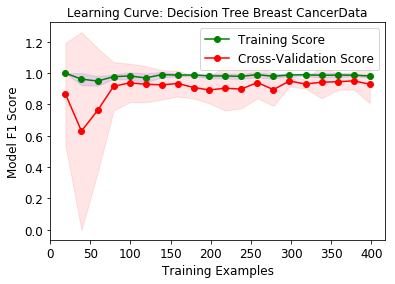

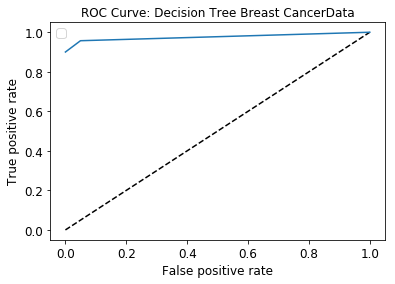

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.00753
Model Prediction Time (s): 0.00023

F1 Score:  0.95
Accuracy:  0.96     AUC:       0.95
Precision: 1.00     Recall:    0.90
*****************************************************


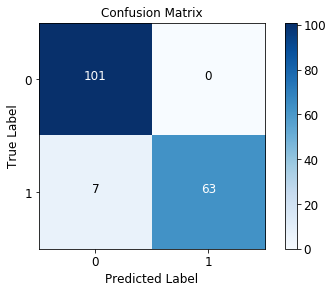

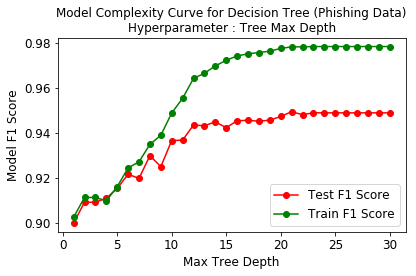

Per Hyperparameter tuning, best parameters are:
{'max_depth': 8, 'min_samples_leaf': 57}


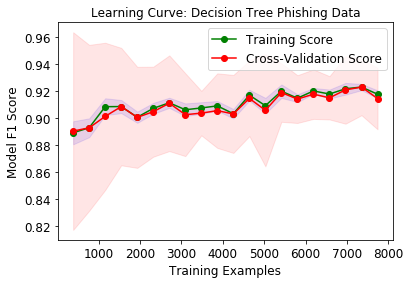

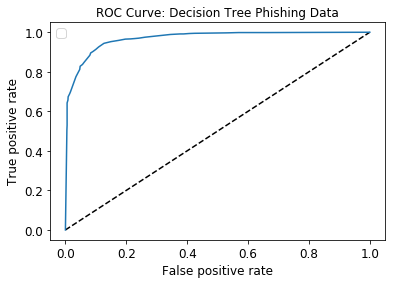

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.01115
Model Prediction Time (s): 0.00100

F1 Score:  0.92
Accuracy:  0.91     AUC:       0.91
Precision: 0.91     Recall:    0.94
*****************************************************


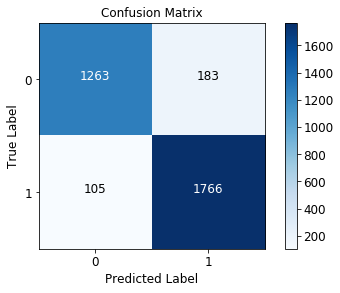

In [43]:
DTree_classifier(X_can_train, y_can_train, X_can_test, y_can_test,title="Model Complexity Curve for Decision Tree (Breast Cancer Data)\nHyperparameter : Tree Max Depth")
start_leaf_n = round(0.005*len(X_can_train))
end_leaf_n = round(0.05*len(X_can_train)) #leaf nodes of size [0.5%, 5% will be tested]
max_depth, min_samples_leaf = TreeGridSearchCV(start_leaf_n,end_leaf_n,X_can_train,y_can_train)
estimator_can = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=100, criterion='entropy')
train_samp_can, DT_train_score_can, DT_fit_time_can, DT_pred_time_can = plot_learning_curve(estimator_can, 5, X_can_train, y_can_train,title="Decision Tree Breast CancerData")
DTree_fp_can, DTree_tp_can = final_classifier_evaluation(estimator_can, X_can_train, X_can_test, y_can_train, y_can_test, title="Decision Tree Breast CancerData")

DTree_classifier(X_ph_train, y_ph_train, X_ph_test, y_ph_test,title="Model Complexity Curve for Decision Tree (Phishing Data)\nHyperparameter : Tree Max Depth")
start_leaf_n = round(0.005*len(X_ph_train))
end_leaf_n = round(0.05*len(X_ph_train)) #leaf nodes of size [0.5%, 5% will be tested]
max_depth, min_samples_leaf = TreeGridSearchCV(start_leaf_n,end_leaf_n,X_ph_train,y_ph_train)
estimator_phish = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=100, criterion='entropy')
train_samp_phish, DT_train_score_phish, DT_fit_time_phish, DT_pred_time_phish = plot_learning_curve(estimator_phish, 10, X_ph_train, y_ph_train,title="Decision Tree Phishing Data")
DTree_fp_phish, DTree_tp_phish = final_classifier_evaluation(estimator_phish, X_ph_train, X_ph_test, y_ph_train, y_ph_test, title="Decision Tree Phishing Data")

# k-Nearest Neighbor Classifier
In this section constructed a K-nearest neighbors classifier. The hyperparameter will be n_neighbors. There is no distnace metrics and euclidean distance was used for all models. The Model Complexity curve will show F1 score as a function of number of neighbors.

In [47]:
def kNN_classifier(X_train, y_train, X_test, y_test, title):
    f1_test = []
    f1_train = []
    klist = np.linspace(1,250,25).astype('int')
    for i in klist:
        clf = kNN(n_neighbors=i,n_jobs=-1)
        clf.fit(X_train,y_train)
        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        f1_test.append(f1_score(y_test, y_pred_test))
        f1_train.append(f1_score(y_train, y_pred_train))
        
    plt.plot(klist, f1_test, 'o-', color='r', label='Test F1 Score')
    plt.plot(klist, f1_train, 'o-', color = 'g', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('No. Neighbors')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

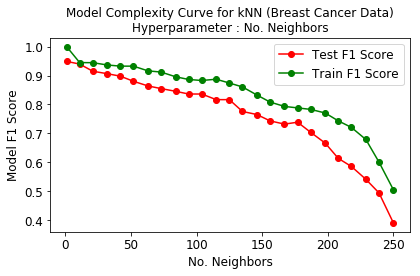

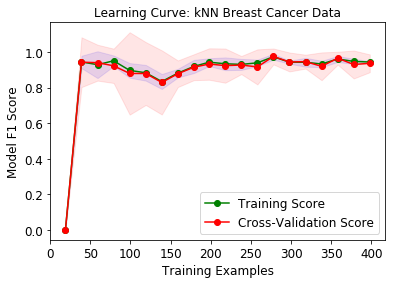

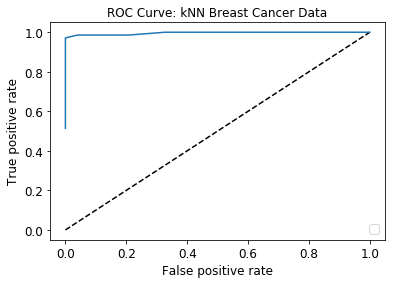

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.00250
Model Prediction Time (s): 0.27711

F1 Score:  0.91
Accuracy:  0.93     AUC:       0.91
Precision: 1.00     Recall:    0.83
*****************************************************


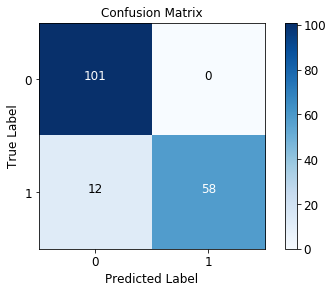

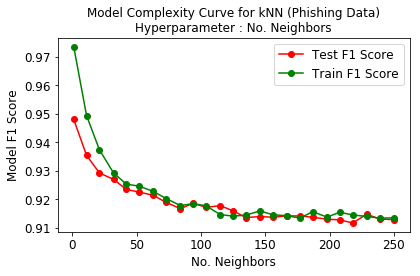

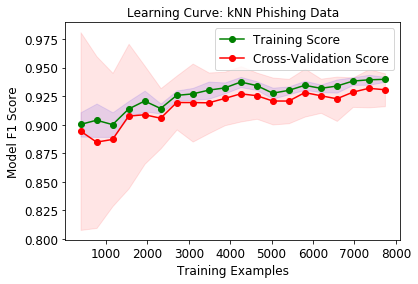

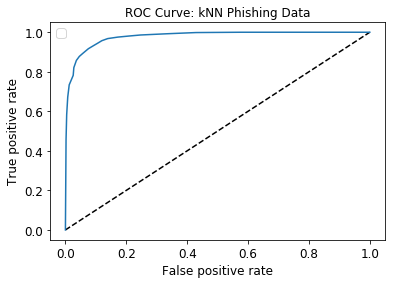

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.10591
Model Prediction Time (s): 1.17967

F1 Score:  0.93
Accuracy:  0.92     AUC:       0.92
Precision: 0.94     Recall:    0.92
*****************************************************


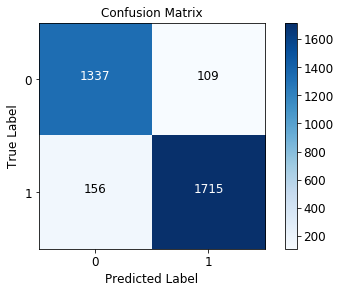

In [53]:
kNN_classifier(X_can_train, y_can_train, X_can_test, y_can_test,title="Model Complexity Curve for kNN (Breast Cancer Data)\nHyperparameter : No. Neighbors")
estimator_can = kNN(n_neighbors=14, n_jobs=-1)
train_samp_can, kNN_train_score_can, kNN_fit_time_can, kNN_pred_time_can = plot_learning_curve(estimator_can, 5, X_can_train, y_can_train,title="kNN Breast Cancer Data")
KNN_fp_can, KNN_tp_can = final_classifier_evaluation(estimator_can, X_can_train, X_can_test, y_can_train, y_can_test,  title="kNN Breast Cancer Data")

kNN_classifier(X_ph_train, y_ph_train, X_ph_test, y_ph_test,title="Model Complexity Curve for kNN (Phishing Data)\nHyperparameter : No. Neighbors")
estimator_phish = kNN(n_neighbors=20, n_jobs=-1)
train_samp_phish, kNN_train_score_phish, kNN_fit_time_phish, kNN_pred_time_phish = plot_learning_curve(estimator_phish,10, X_ph_train, y_ph_train,title="kNN Phishing Data")
KNN_fp_ph, KNN_tp_ph = final_classifier_evaluation(estimator_phish, X_ph_train, X_ph_test, y_ph_train, y_ph_test, title="kNN Phishing Data")

# Neural Network Classifier
In this section constructed a forward-feed neural network which computes weights via backpropagation (a multilayer perceptron). The main hyperparameter was the number of hidden nodes in a network defined by a single hidden layer, while others that could be searched over in grid search are activation function, and learning rate.

In [56]:
def NN_classifier(X_train, y_train, X_test, y_test, title):
    f1_test = []
    f1_train = []
    hlist = np.linspace(1,150,30).astype('int')
    for i in hlist:         
            clf = MLPClassifier(hidden_layer_sizes=(i,), solver='adam', activation='logistic', 
                                learning_rate_init=0.05,max_iter=1000, random_state=100)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(f1_score(y_test, y_pred_test))
            f1_train.append(f1_score(y_train, y_pred_train))
      
    plt.plot(hlist, f1_test, 'o-', color='r', label='Test F1 Score')
    plt.plot(hlist, f1_train, 'o-', color = 'g', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('No. Hidden Units')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    
def NNGridSearchCV(X_train, y_train):
    #parameters to search:
    #number of hidden units
    #learning_rate
    h_units = [5, 10, 20, 30, 40, 50, 75, 100]
    learning_rates = [0.01, 0.05, .1]
    param_grid = {'hidden_layer_sizes': h_units, 'learning_rate_init': learning_rates}

    net = GridSearchCV(estimator = MLPClassifier(solver='adam',activation='logistic',random_state=100),
                       param_grid=param_grid, cv=10)
    net.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(net.best_params_)
    return net.best_params_['hidden_layer_sizes'], net.best_params_['learning_rate_init']

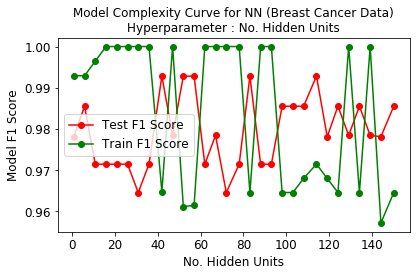

Per Hyperparameter tuning, best parameters are:
{'learning_rate_init': 0.1, 'hidden_layer_sizes': 30}


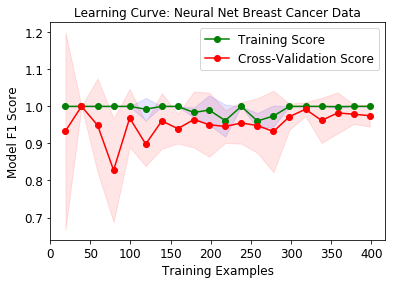

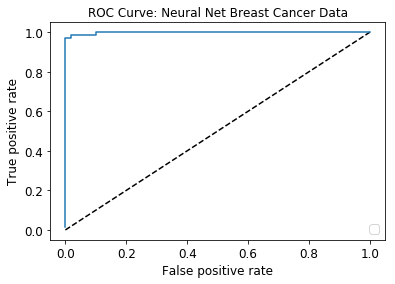

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.16911
Model Prediction Time (s): 0.00111

F1 Score:  0.98
Accuracy:  0.98     AUC:       0.98
Precision: 0.99     Recall:    0.97
*****************************************************


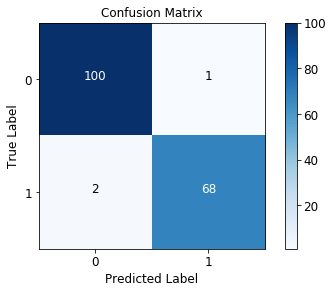

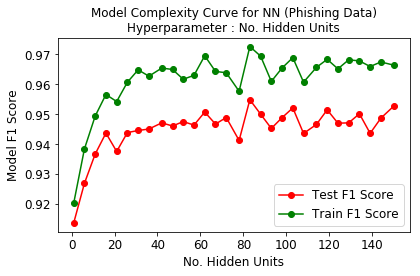

Per Hyperparameter tuning, best parameters are:
{'learning_rate_init': 0.05, 'hidden_layer_sizes': 50}


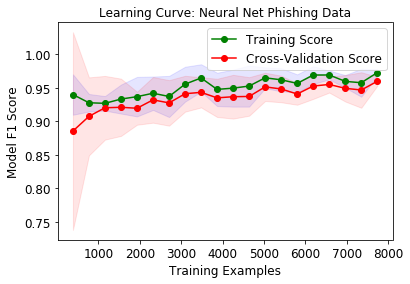

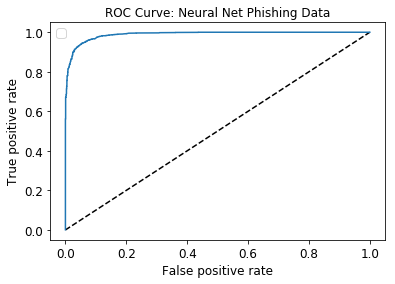

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   1.63159
Model Prediction Time (s): 0.01126

F1 Score:  0.95
Accuracy:  0.94     AUC:       0.94
Precision: 0.95     Recall:    0.95
*****************************************************


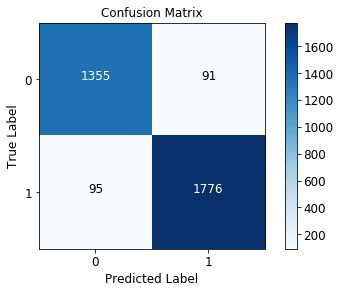

In [57]:
hlist = np.linspace(1,150,30).astype('int')
NN_classifier(X_can_train, y_can_train, X_can_test, y_can_test,title="Model Complexity Curve for NN (Breast Cancer Data)\nHyperparameter : No. Hidden Units")
h_units, learn_rate = NNGridSearchCV(X_can_train, y_can_train)
estimator_can = MLPClassifier(hidden_layer_sizes=(h_units,), solver='adam', activation='logistic', 
                               learning_rate_init=learn_rate, random_state=100)
train_samp_can, NN_train_score_can, NN_fit_time_can, NN_pred_time_can = plot_learning_curve(estimator_can,5, X_can_train, y_can_train,title="Neural Net Breast Cancer Data")
NN_fp_can, NN_tp_can = final_classifier_evaluation(estimator_can, X_can_train, X_can_test, y_can_train, y_can_test, title="Neural Net Breast Cancer Data")


NN_classifier(X_ph_train, y_ph_train, X_ph_test, y_ph_test,title="Model Complexity Curve for NN (Phishing Data)\nHyperparameter : No. Hidden Units")
h_units, learn_rate = NNGridSearchCV(X_ph_train, y_ph_train)
estimator_phish = MLPClassifier(hidden_layer_sizes=(h_units,), solver='adam', activation='logistic', 
                               learning_rate_init=learn_rate, random_state=100)
train_samp_phish, NN_train_score_phish, NN_fit_time_phish, NN_pred_time_phish = plot_learning_curve(estimator_phish,10, X_ph_train, y_ph_train,title="Neural Net Phishing Data")
NN_fp_ph, NN_tp_ph = final_classifier_evaluation(estimator_phish, X_ph_train, X_ph_test, y_ph_train, y_ph_test, title="Neural Net Phishing Data")

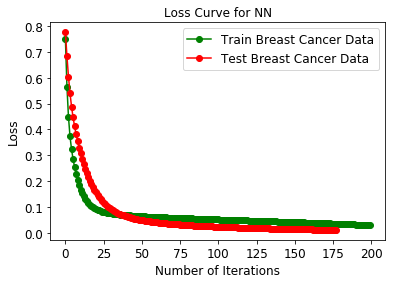

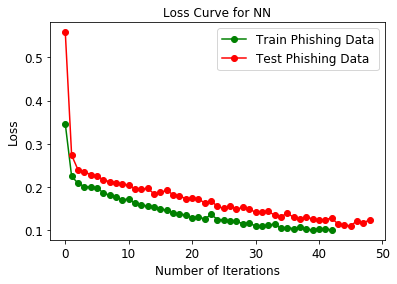

In [100]:

estimator_can = MLPClassifier(hidden_layer_sizes=(30,), solver='adam', activation='logistic', 
                               learning_rate_init=0.01, random_state=100, max_iter = 200)
estimator_can.fit(X_can_train, y_can_train)
loss_values_can = estimator_can.loss_curve_
estimator_can.fit(X_can_test, y_can_test)
loss_can_test = estimator_can.loss_curve_

estimator_phish = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', 
                               learning_rate_init=0.05, random_state=100, max_iter = 200)
estimator_phish.fit(X_ph_train, y_ph_train)
loss_values_ph = estimator_phish.loss_curve_
estimator_phish.fit(X_ph_test, y_ph_test)
loss_ph_test = estimator_phish.loss_curve_


plt.figure()
plt.title("Loss Curve for NN")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.plot(loss_values_can, 'o-', color="g", label="Train Breast Cancer Data")
plt.plot(loss_can_test, 'o-', color="r", label="Test Breast Cancer Data")
plt.legend(loc="best")
plt.show()



plt.figure()
plt.title("Loss Curve for NN")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.plot(loss_values_ph, 'o-', color="g", label="Train Phishing Data")
plt.plot(loss_ph_test, 'o-', color="r", label="Test Phishing Data")
plt.legend(loc="best")
plt.show()

# Support Vector Machine Classifier
In this section build a support vector machine classifier. The primary hyperparameter will be kernel function: linear, polynomial, rbf (radial basis function), and sigmoid. Linear SVM was used to classify both the datasets.

In [84]:
def SVM_classifier(X_train, y_train, X_test, y_test, title):
    f1_test = []
    f1_train = []
    kernel_func = ['linear','poly','rbf','sigmoid']
    for i in kernel_func:         
            if i == 'poly':
                for j in [2,3,4,5,6,7,8]:
                    clf = svm.SVC(kernel=i, degree=j,random_state=100, probability=True)
                    clf.fit(X_train, y_train)
                    y_pred_test = clf.predict(X_test)
                    y_pred_train = clf.predict(X_train)
                    f1_test.append(f1_score(y_test, y_pred_test))
                    f1_train.append(f1_score(y_train, y_pred_train))
            else:    
                clf = svm.SVC(kernel=i, random_state=100)
                clf.fit(X_train, y_train)
                y_pred_test = clf.predict(X_test)
                y_pred_train = clf.predict(X_train)
                f1_test.append(f1_score(y_test, y_pred_test))
                f1_train.append(f1_score(y_train, y_pred_train))
                
    xvals = ['linear','poly2','poly3','poly4','poly5','poly6','poly7','poly8','rbf','sigmoid']
    plt.plot(xvals, f1_test, 'o-', color='r', label='Test F1 Score')
    plt.plot(xvals, f1_train, 'o-', color = 'g', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('Kernel Function')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
def SVMGridSearchCV(X_train, y_train):
    #parameters to search:
    #penalty parameter, C
    #
    Cs = [1e-4, 1e-3, 1e-2, 1e01, 1]
    gammas = [1,10,100]
    param_grid = {'C': Cs, 'gamma': gammas}

    clf = GridSearchCV(estimator = svm.SVC(kernel='linear',random_state=100),
                       param_grid=param_grid, cv=10)
    clf.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(clf.best_params_)
    return clf.best_params_['C'], clf.best_params_['gamma']

    
def svm_classifier_evaluation(clf,X_train, X_test, y_train, y_test, title):
    
    start_time = timeit.default_timer()
    clf.fit(X_train, y_train)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    start_time = timeit.default_timer()    
    y_pred = clf.predict(X_test)
    end_time = timeit.default_timer()
    pred_time = end_time - start_time
    
    auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    cm = confusion_matrix(y_test,y_pred)
    fpr_lm, tpr_lm, _ = roc_curve(y_test, y_pred)
    plot_roc(fpr_lm, tpr_lm, title)
    print("Model Evaluation Metrics Using Untouched Test Dataset")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.5f}".format(training_time))
    print("Model Prediction Time (s): "+"{:.5f}\n".format(pred_time))
    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy)+"     AUC:       "+"{:.2f}".format(auc))
    print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
    plt.figure()
    plot_confusion_matrix(cm, classes=["0","1"], title='Confusion Matrix')
    plt.show()
    return fpr_lm, tpr_lm

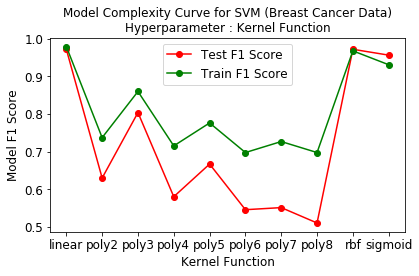

Per Hyperparameter tuning, best parameters are:
{'C': 1, 'gamma': 1}


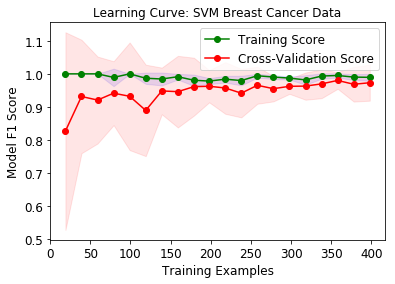

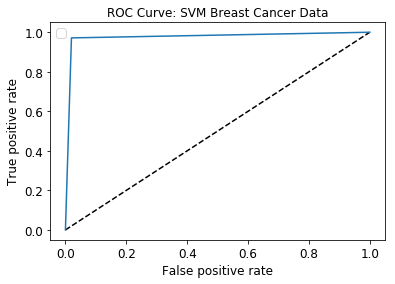

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.00201
Model Prediction Time (s): 0.00025

F1 Score:  0.97
Accuracy:  0.98     AUC:       0.98
Precision: 0.97     Recall:    0.97
*****************************************************


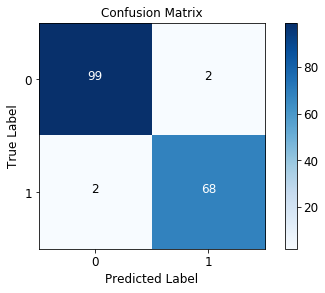

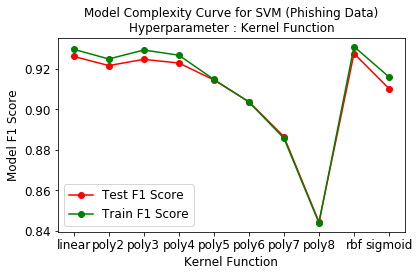

Per Hyperparameter tuning, best parameters are:
{'C': 10.0, 'gamma': 1}


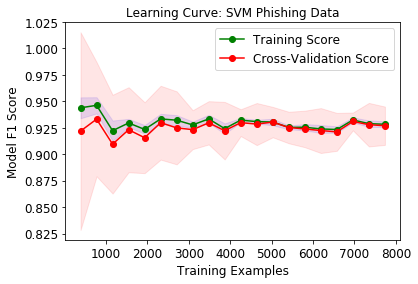

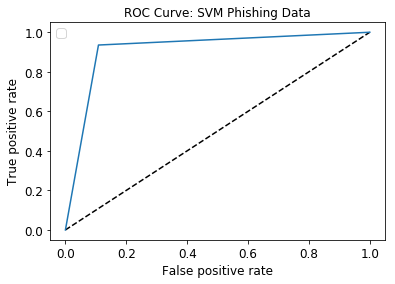

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   2.66005
Model Prediction Time (s): 0.15089

F1 Score:  0.93
Accuracy:  0.92     AUC:       0.91
Precision: 0.92     Recall:    0.94
*****************************************************


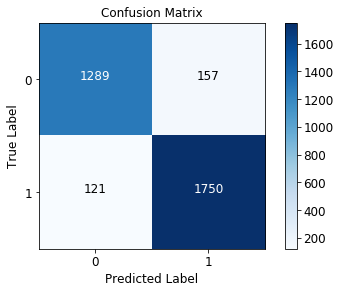

In [85]:
SVM_classifier(X_can_train, y_can_train, X_can_test, y_can_test,title="Model Complexity Curve for SVM (Breast Cancer Data)\nHyperparameter : Kernel Function")
C_val, gamma_val = SVMGridSearchCV(X_can_train, y_can_train)
estimator_bank = svm.SVC(C=C_val, gamma=gamma_val, kernel='linear', random_state=100)
train_samp_can, SVM_train_score_can, SVM_fit_time_can, SVM_pred_time_can= plot_learning_curve(estimator_bank,5, X_can_train, y_can_train, title="SVM Breast Cancer Data")
SVM_fp_can, SVM_tp_can = svm_classifier_evaluation(estimator_bank, X_can_train, X_can_test, y_can_train, y_can_test, title="SVM Breast Cancer Data")

SVM_classifier(X_ph_train, y_ph_train, X_ph_test, y_ph_test,title="Model Complexity Curve for SVM (Phishing Data)\nHyperparameter : Kernel Function")
C_val, gamma_val = SVMGridSearchCV(X_ph_train, y_ph_train)
estimator_phish = svm.SVC(C=C_val, gamma=gamma_val, kernel='linear', random_state=100)
train_samp_phish, SVM_train_score_phish, SVM_fit_time_phish, SVM_pred_time_phish = plot_learning_curve(estimator_phish,10, X_ph_train, y_ph_train,title="SVM Phishing Data")
SVM_fp_ph, SVM_tp_ph = svm_classifier_evaluation(estimator_phish, X_ph_train, X_ph_test, y_ph_train, y_ph_test, title="SVM Phishing Data")

# Boosting(Adaboost)
In this section constructed an Adaboost classifier. Decision stumps were used as weak learners. The hyperparameters are number of estimators and learning rate which will determine the contribution of each tree classifier.

In [70]:
def AdaBoost_classifier(X_train, y_train, X_test, y_test, max_depth, min_samples_leaf, title):
    f1_test = []
    f1_train = []
    n_estimators = np.linspace(1,250,40).astype('int')
    dt_stump = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    for i in n_estimators:         
            
            clf = AdaBoostClassifier(base_estimator=dt_stump, n_estimators=i, random_state=100)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(f1_score(y_test, y_pred_test))
            f1_train.append(f1_score(y_train, y_pred_train))
      
    plt.plot(n_estimators, f1_test, 'o-', color='r', label='Test F1 Score')
    plt.plot(n_estimators, f1_train, 'o-', color = 'g', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('No. Estimators')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

def BoostedGridSearchCV(start_leaf_n, end_leaf_n, X_train, y_train):
    #parameters to search:
    #n_estimators, learning_rate, max_depth, min_samples_leaf
    param_grid = {'n_estimators': np.linspace(10,100,3).round().astype('int'),
                  'learning_rate': np.linspace(.001,.1,3)}

    boost = GridSearchCV(estimator = AdaBoostClassifier(), param_grid=param_grid, cv=10)
    boost.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(boost.best_params_)
    return boost.best_params_['n_estimators'], boost.best_params_['learning_rate']

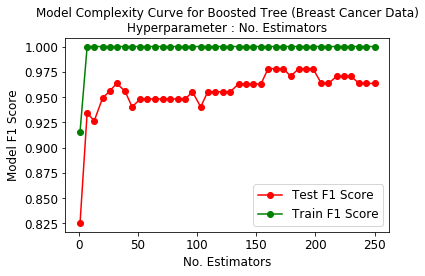

Per Hyperparameter tuning, best parameters are:
{'n_estimators': 100, 'learning_rate': 0.0505}


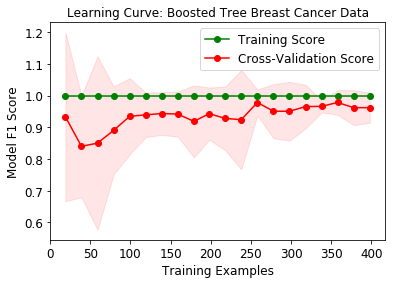

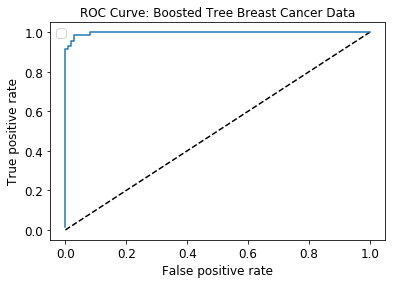

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.38287
Model Prediction Time (s): 0.01927

F1 Score:  0.96
Accuracy:  0.96     AUC:       0.96
Precision: 0.97     Recall:    0.94
*****************************************************


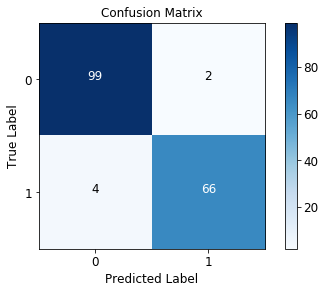

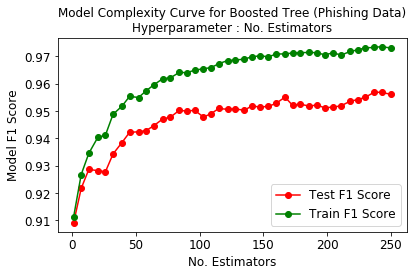

Per Hyperparameter tuning, best parameters are:
{'n_estimators': 100, 'learning_rate': 0.1}


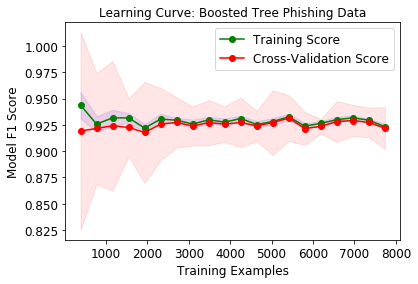

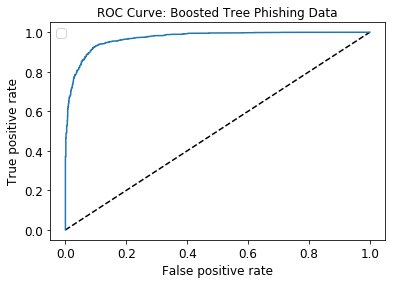

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.69439
Model Prediction Time (s): 0.10359

F1 Score:  0.93
Accuracy:  0.92     AUC:       0.92
Precision: 0.92     Recall:    0.93
*****************************************************


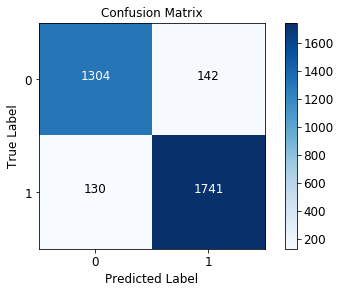

In [76]:
AdaBoost_classifier(X_can_train, y_can_train, X_can_test, y_can_test, 3, 50, title="Model Complexity Curve for Boosted Tree (Breast Cancer Data)\nHyperparameter : No. Estimators")
start_leaf_n = round(0.005*len(X_can_train))
end_leaf_n = round(0.05*len(X_can_train)) #leaf nodes of size [0.5%, 5% will be tested]
n_est, learn_rate = BoostedGridSearchCV(start_leaf_n,end_leaf_n, X_can_train, y_can_train)
dt_stump = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
estimator_can = AdaBoostClassifier(base_estimator=dt_stump, n_estimators=n_est, random_state=100)

train_samp_can, BT_train_score_can, BT_fit_time_can, BT_pred_time_can = plot_learning_curve(estimator_can, 5, X_can_train, y_can_train,title="Boosted Tree Breast Cancer Data")
BT_fp_can, BT_tp_can = final_classifier_evaluation(estimator_can, X_can_train, X_can_test, y_can_train, y_can_test, title="Boosted Tree Breast Cancer Data")


AdaBoost_classifier(X_ph_train, y_ph_train, X_ph_test, y_ph_test, 3, 50, title="Model Complexity Curve for Boosted Tree (Phishing Data)\nHyperparameter : No. Estimators")
start_leaf_n = round(0.005*len(X_ph_train))
end_leaf_n = round(0.05*len(X_ph_train)) #leaf nodes of size [0.5%, 5% will be tested]
n_est, learn_rate = BoostedGridSearchCV(start_leaf_n,end_leaf_n,X_ph_train,y_ph_train)
dt_stump = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
estimator_phish = AdaBoostClassifier(base_estimator=dt_stump, n_estimators=n_est, random_state=100)

train_samp_phish, BT_train_score_phish, BT_fit_time_phish, BT_pred_time_phish = plot_learning_curve(estimator_phish, 10, X_ph_train, y_ph_train,title="Boosted Tree Phishing Data")
BT_fp_phish, BT_tp_phish = final_classifier_evaluation(estimator_phish, X_ph_train, X_ph_test, y_ph_train, y_ph_test, title="Boosted Tree Phishing Data")

# Compare the classifiers
The 5 classifiers were compared with respect to training time, prediction time, area under ROC curve and F1 score.

In [78]:
def compare_fit_time(n,NNtime, SMVtime, kNNtime, DTtime, BTtime, title):
    
    plt.figure()
    plt.title("Model Training Times: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model Training Time (s)")
    plt.plot(n, NNtime, '-', color="b", label="Neural Network")
    plt.plot(n, SMVtime, '-', color="r", label="SVM")
    plt.plot(n, kNNtime, '-', color="g", label="kNN")
    plt.plot(n, DTtime, '-', color="m", label="Decision Tree")
    plt.plot(n, BTtime, '-', color="k", label="Boosted Tree")
    plt.legend(loc="best")
    plt.show()
    
def compare_pred_time(n,NNpred, SMVpred, kNNpred, DTpred, BTpred, title):
    
    plt.figure()
    plt.title("Model Prediction Times: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model Prediction Time (s)")
    plt.plot(n, NNpred, '-', color="b", label="Neural Network")
    plt.plot(n, SMVpred, '-', color="r", label="SVM")
    plt.plot(n, kNNpred, '-', color="g", label="kNN")
    plt.plot(n, DTpred, '-', color="m", label="Decision Tree")
    plt.plot(n, BTpred, '-', color="k", label="Boosted Tree")
    plt.legend(loc="best")
    plt.show()
    
def compare_roc(NN_fp, NN_tp, SVM_fp, SVM_tp, kNN_fp, kNN_tp, DT_fp, DT_tp, BT_fp, BT_tp, title):
    
    plt.figure()
    plt.title("Classifier ROC: " + title)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.plot(NN_fp, NN_tp, '-', color="b", label="Neural Network")
    plt.plot(SVM_fp, SVM_tp, '-', color="r", label="SVM")
    plt.plot(kNN_fp, kNN_tp, '-', color="g", label="kNN")
    plt.plot(DT_fp, DT_tp, '-', color="m", label="Decision Tree")
    plt.plot(BT_fp, BT_tp, '-', color="k", label="Boosted Tree")
    plt.legend(loc="best")
    plt.show()

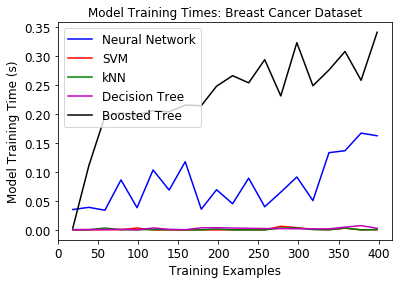

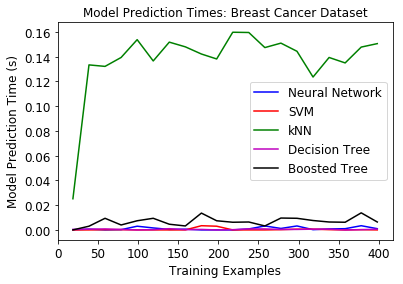

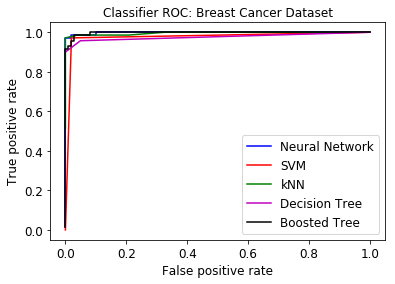

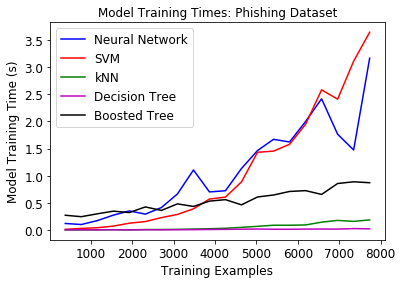

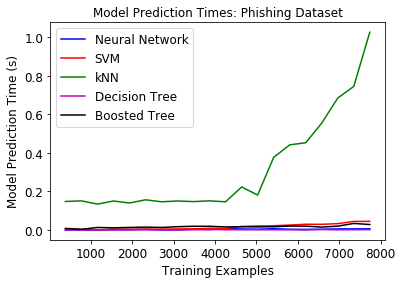

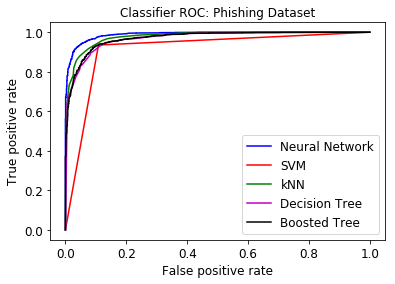

In [101]:
compare_fit_time(train_samp_can, NN_fit_time_can, SVM_fit_time_can, kNN_fit_time_can, 
                 DT_fit_time_can, BT_fit_time_can, 'Breast Cancer Dataset')              
compare_pred_time(train_samp_can, NN_pred_time_can, SVM_pred_time_can, kNN_pred_time_can, 
                 DT_pred_time_can, BT_pred_time_can, 'Breast Cancer Dataset')  
compare_roc(NN_fp_can, NN_tp_can, SVM_fp_can, SVM_tp_can, KNN_fp_can, KNN_tp_can, 
            DTree_fp_can, DTree_tp_can, BT_fp_can, BT_tp_can, 'Breast Cancer Dataset')


compare_fit_time(train_samp_phish, NN_fit_time_phish, SVM_fit_time_phish, kNN_fit_time_phish, 
                 DT_fit_time_phish, BT_fit_time_phish, 'Phishing Dataset')              
compare_pred_time(train_samp_phish, NN_pred_time_phish, SVM_pred_time_phish, kNN_pred_time_phish, 
                 DT_pred_time_phish, BT_pred_time_phish, 'Phishing Dataset')  
compare_roc(NN_fp_ph, NN_tp_ph, SVM_fp_ph, SVM_tp_ph, KNN_fp_ph, KNN_tp_ph, 
            DTree_fp_phish, DTree_tp_phish, BT_fp_phish, BT_tp_phish, 'Phishing Dataset')

In [103]:
classifiers = ('Decision tree', 'kNN', 'Neural network', 'SVM', 'AdaBoost')
y_pos = np.arange(len(classifiers))
f1_score_ph=(0.92, 0.93, 0.95, 0.93,0.93 )
f1_score_can=(0.95, 0.91, 0.98,0.97, 0.96 )

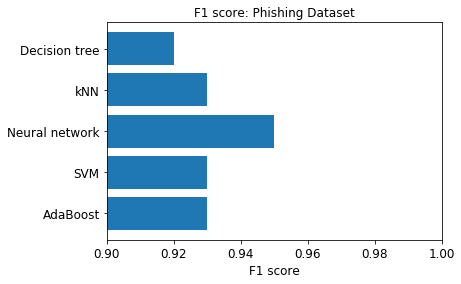

In [106]:
plt.figure()
plt.barh(y_pos, f1_score_ph)
plt.gca().set_yticks(y_pos)
plt.gca().set_xlim(0.9, 1.0)
plt.gca().set_yticklabels(classifiers)
plt.gca().invert_yaxis()  # labels read top-to-bottom
plt.title('F1 score: Phishing Dataset')
plt.xlabel('F1 score')
plt.show()

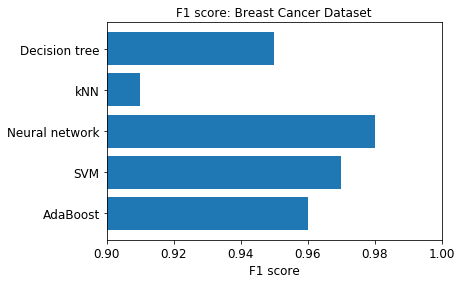

In [107]:
plt.figure()
plt.barh(y_pos, f1_score_can)
plt.gca().set_yticks(y_pos)
plt.gca().set_xlim(0.9, 1.0)
plt.gca().set_yticklabels(classifiers)
plt.gca().invert_yaxis()  # labels read top-to-bottom
plt.title('F1 score: Breast Cancer Dataset')
plt.xlabel('F1 score')
plt.show()